In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import os
# Data Vis
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
#sns.set(style='white', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')

In [2]:
# Define IAM role
import boto3
import re
import sagemaker
from sagemaker.predictor import csv_serializer
role = sagemaker.get_execution_role()
print(role)
sess = sagemaker.Session()
#bucket = 'hr-attrition'
bucket = 'hr-attrition'
prefix = 'sagemaker/hr-attrition'

arn:aws:iam::420696774360:role/service-role/AmazonSageMaker-ExecutionRole-20181220T094966


In [3]:
data_key_train = 'hr_attrition_train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key_train)

train=pd.read_csv(data_location)
train_final=train

In [4]:
data_key_test = 'hr_attrition_train.csv'
data_location_test = 's3://{}/{}'.format(bucket, data_key_test)
test=pd.read_csv(data_location_test)

In [5]:
train_final['id'] = train_final['left']
train_final=train_final.drop('left', axis=1)

train_final=train_final.rename(columns={'id': 'left'})

train_final.head()

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


In [6]:
data_key_test = 'hr_attrition_test.csv'
#data_location = 's3://{}/{}'.format(bucket, data_key)
data_location_test = 's3://{}/{}'.format(bucket, data_key_test)
test = pd.read_csv(data_location_test)

In [7]:
pd.set_option('display.max_columns',999)
test.head()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary
0,13001,0.62,0.94,4,252,4,0,0,accounting,low
1,13002,0.38,0.52,2,171,3,0,0,accounting,medium
2,13003,0.80,0.77,4,194,3,0,0,accounting,medium
3,13004,0.61,0.42,3,104,2,0,0,hr,medium
4,13005,0.61,0.56,4,176,3,0,0,hr,medium


In [8]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [9]:
missing_data(train).head(10)
missing_data(test).head(10)

,Total,Percent
salary,0,0.0
sales,0,0.0
promotion_last_5years,0,0.0
Work_accident,0,0.0
time_spend_company,0,0.0
average_montly_hours,0,0.0
number_project,0,0.0
last_evaluation,0,0.0
satisfaction_level,0,0.0
id,0,0.0


In [10]:
# Get target
target = 'left'

# Get quantitative features and delete the unnccessary features
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
#quantitative.remove('id')


# Get categorical features
categorical = [f for f in train.columns if train.dtypes[f] == 'object']

train_y = train['left']

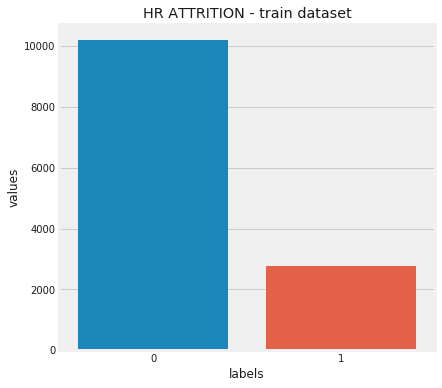

In [11]:
temp = train["left"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('HR ATTRITION - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

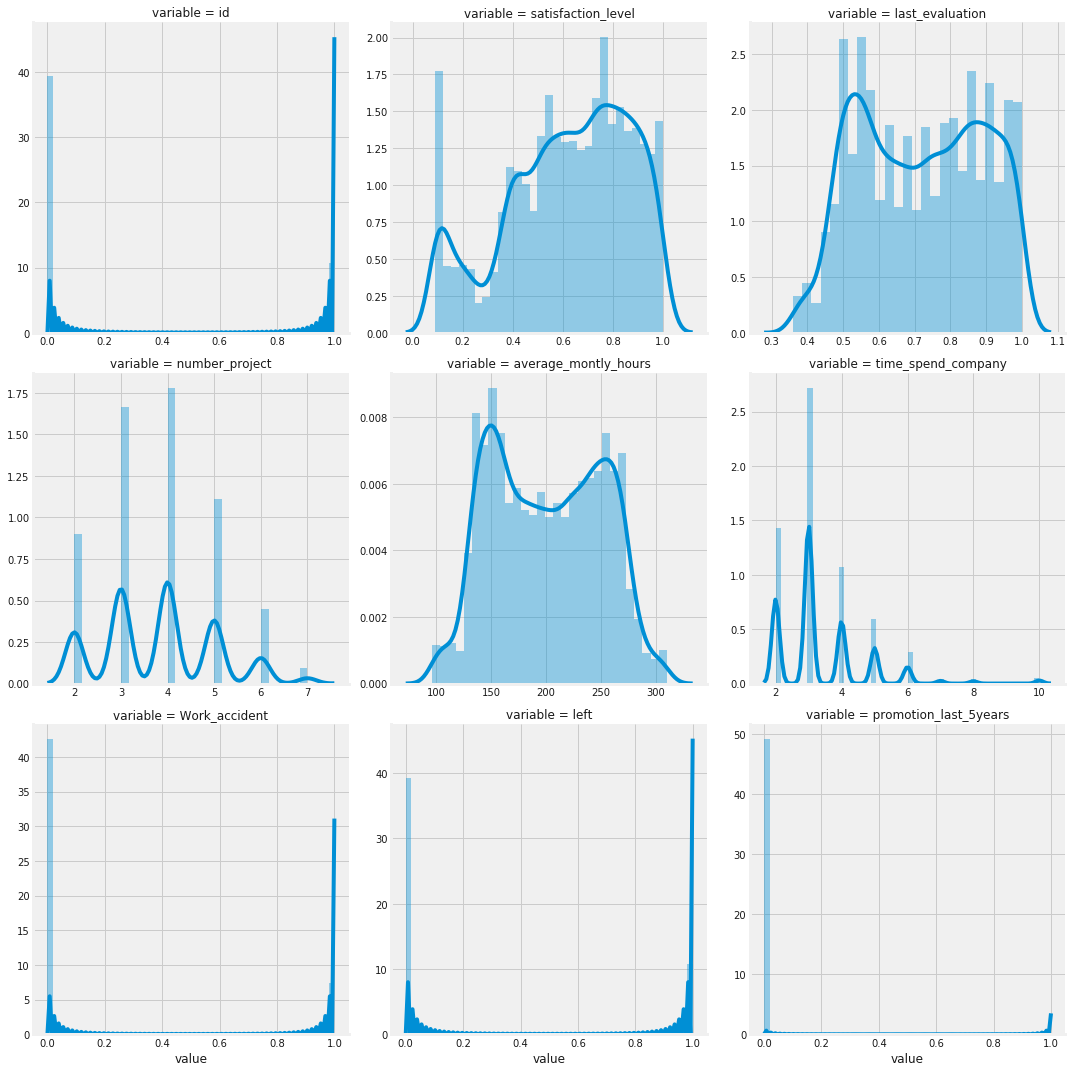

In [12]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(sns.distplot, "value")

In [13]:
satisfaction_bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
train['satisfaction_binned'] = pd.cut(train['satisfaction_level'], satisfaction_bins)
evaluation_bins = [ 0.3, 0.5, 0.7, 0.8, 0.9,1.0]
train['evaluation_binned'] = pd.cut(train['last_evaluation'], evaluation_bins)
monthly_hours_bin = [ 0, 100, 150, 200, 250, 300, 350]
train['monthly_hours_binned'] = pd.cut(train['average_montly_hours'], monthly_hours_bin)

In [14]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of employees': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = train[[feature, 'left']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='left', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of employees",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='left', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

In [15]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[train['left'] != 0]
    t0 = train.loc[train['left'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="left = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="left = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

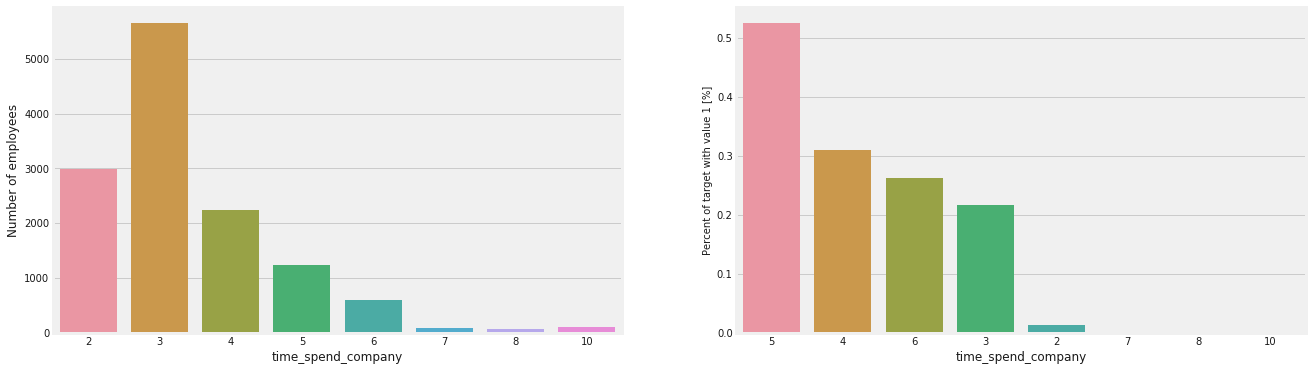

In [16]:
plot_stats('time_spend_company')

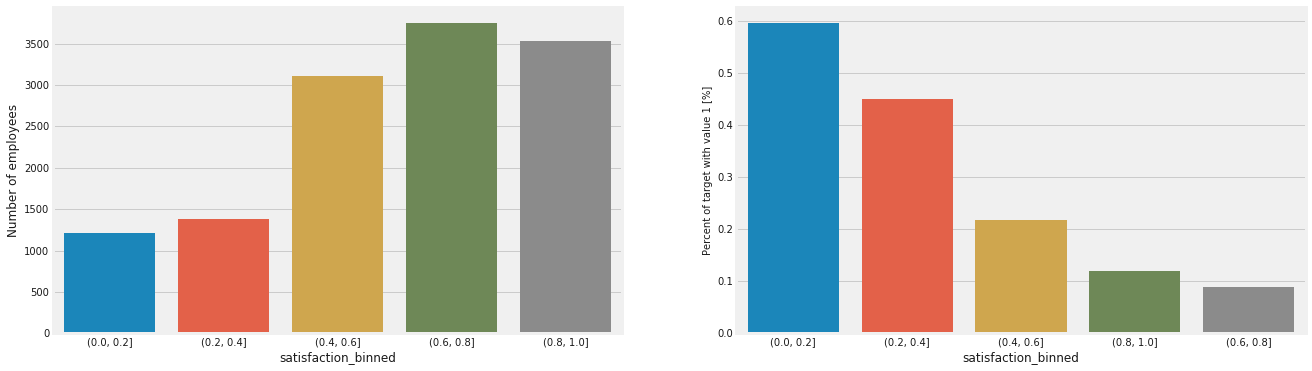

In [17]:
plot_stats('satisfaction_binned')

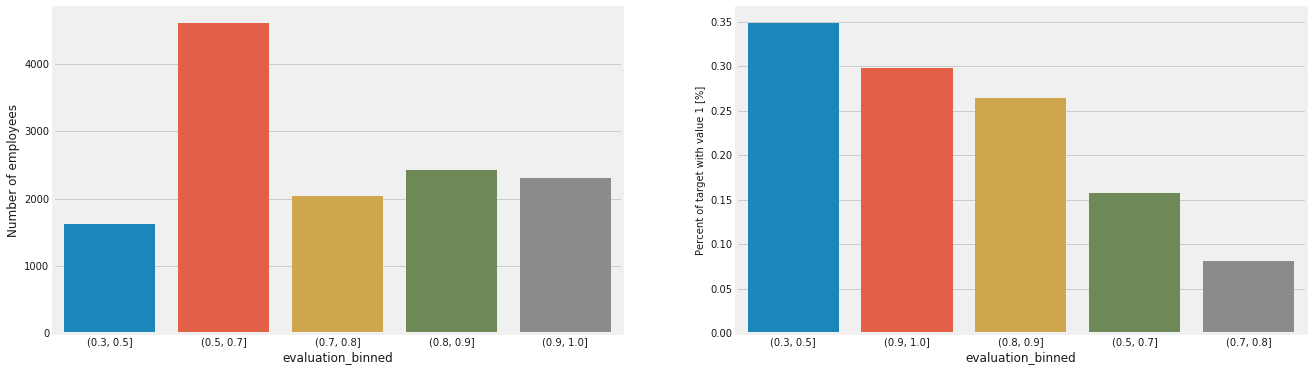

In [18]:
plot_stats('evaluation_binned')

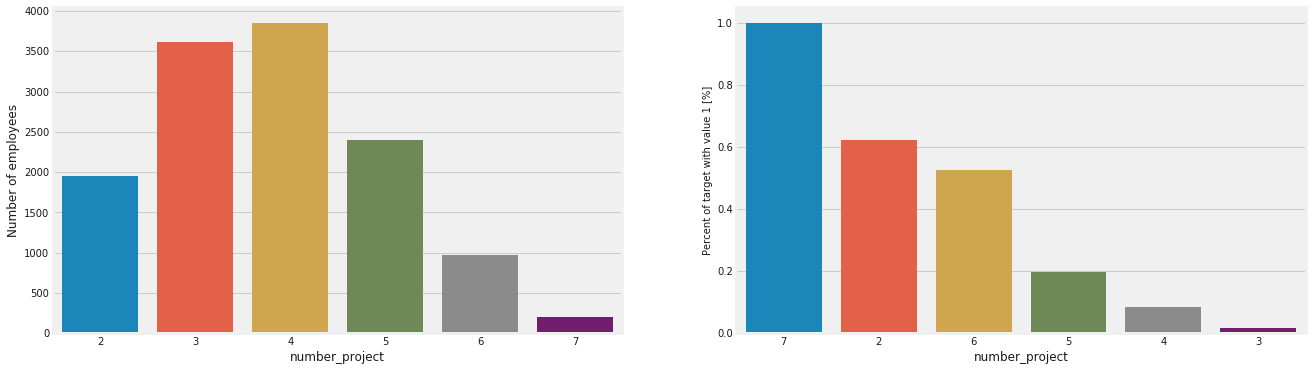

In [19]:
plot_stats('number_project')

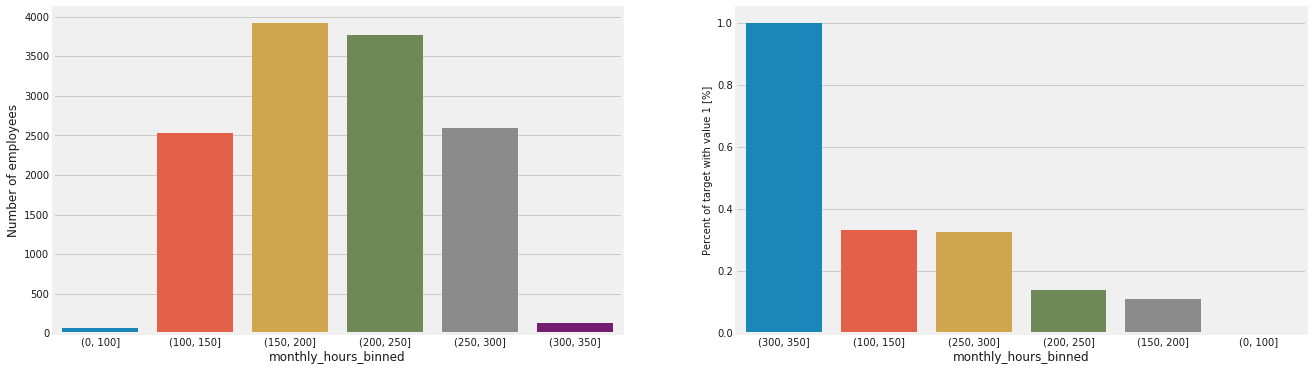

In [20]:
plot_stats('monthly_hours_binned')

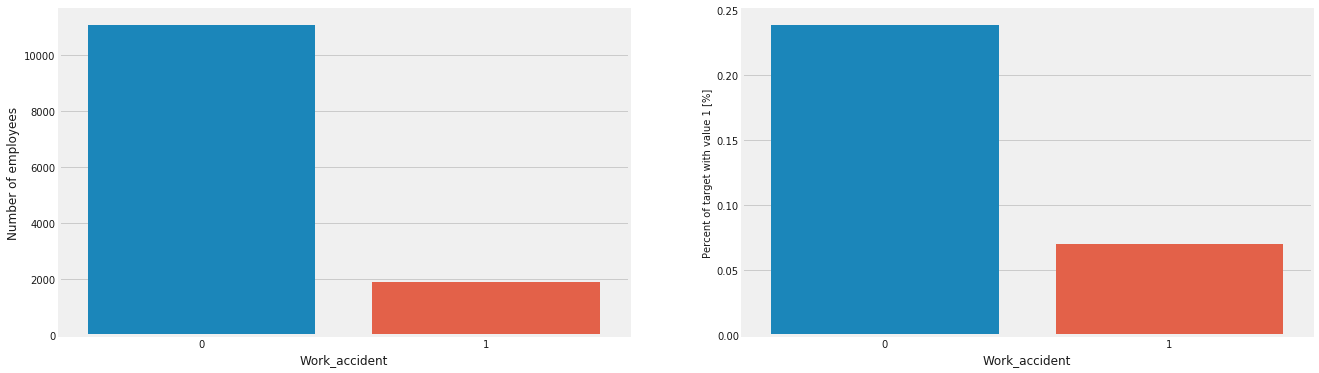

In [21]:
plot_stats('Work_accident')

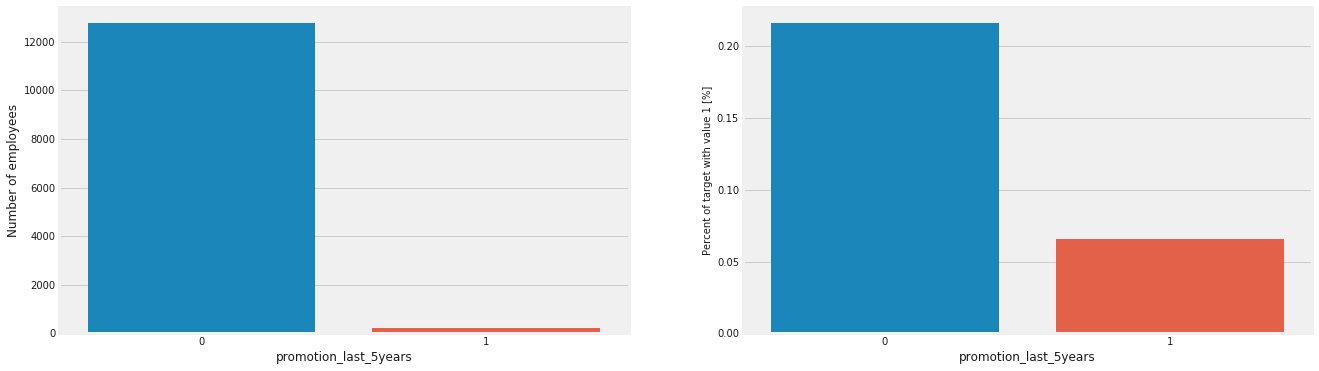

In [22]:
plot_stats('promotion_last_5years')

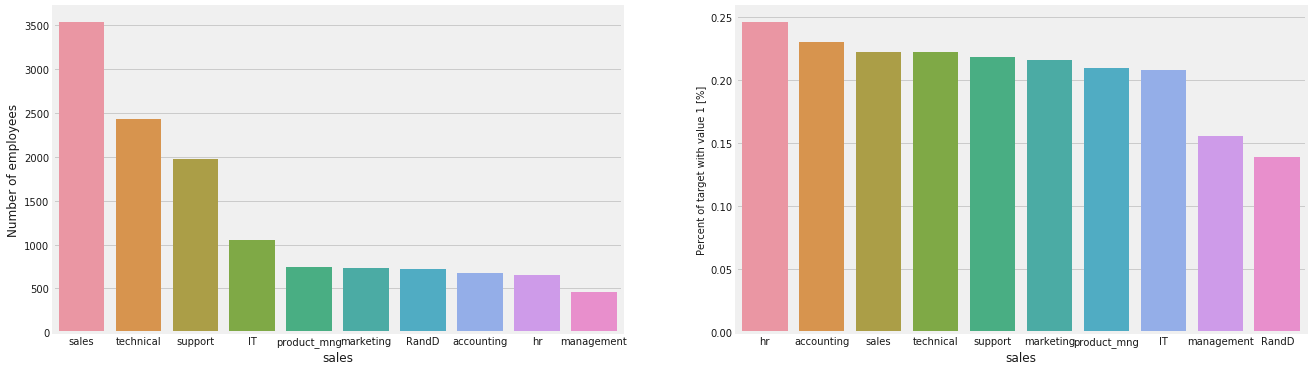

In [23]:
plot_stats('sales')

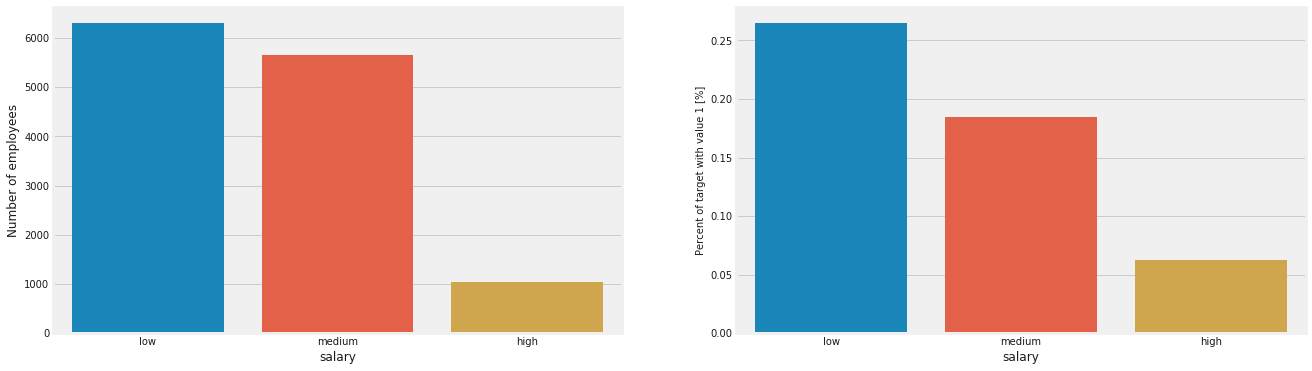

In [24]:
plot_stats('salary')

In [25]:
model_data = pd.get_dummies(train_final)
real_test_data = pd.get_dummies(test)

In [26]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [27]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

train

In [41]:
train_data.head()

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
8159,0,0.89,0.91,4,190,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2091,0,0.73,0.44,2,194,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
658,1,0.38,0.53,2,146,3,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
8625,0,0.79,0.77,4,171,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2689,0,0.59,0.71,2,176,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [28]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [29]:
#s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train.csv'.format(bucket, prefix), content_type='csv')
#s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation.csv'.format(bucket, prefix), content_type='csv')
#s3_input_validation = sagemaker.s3_input(s3_data='s3://hr-attrition//validation/validation.csv')
#data_key_train = 'train.csv'
#s3_input_train = 's3://{}/{}'.format(bucket, data_key_train)
#s3_input_train = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
#s3_input_validation = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [30]:
sess = sagemaker.Session()

xgb_hr_attrition = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb_hr_attrition.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)


In [31]:
xgb_hr_attrition.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2018-12-25-04-27-29-885


2018-12-25 04:27:30 Starting - Starting the training job...
2018-12-25 04:27:32 Starting - Launching requested ML instances...
2018-12-25 04:28:28 Starting - Preparing the instances for training......
2018-12-25 04:29:27 Downloading - Downloading input data...
2018-12-25 04:29:44 Training - Downloading the training image..
Arguments: train
[2018-12-25:04:30:03:INFO] Running standalone xgboost training.
[2018-12-25:04:30:03:INFO] File size need to be processed in the node: 0.56mb. Available memory size in the node: 8392.88mb
[2018-12-25:04:30:03:INFO] Determined delimiter of CSV input is ','
[04:30:03] S3DistributionType set as FullyReplicated
[04:30:03] 9100x20 matrix with 182000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-12-25:04:30:03:INFO] Determined delimiter of CSV input is ','
[04:30:03] S3DistributionType set as FullyReplicated
[04:30:03] 2600x20 matrix with 52000 entries loaded from /opt/ml/input/data/validation?format=csv&label_col

In [32]:
xgb_hr_attrition_predictor = xgb_hr_attrition.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-12-25-04-31-01-417
INFO:sagemaker:Creating endpoint with name xgboost-2018-12-25-04-27-29-885


--------------------------------------------------------------!

In [33]:
xgb_hr_attrition_predictor.content_type = 'text/csv'
xgb_hr_attrition_predictor.serializer = csv_serializer
xgb_hr_attrition_predictor.deserializer = None

In [167]:
real_test_data = real_test_data.drop('id', axis=1)


In [168]:
real_test_data = real_test_data.drop('left', axis = 1)

In [36]:
real_test_data.head()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,13001,0.62,0.94,4,252,4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,13002,0.38,0.52,2,171,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,13003,0.80,0.77,4,194,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,13004,0.61,0.42,3,104,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,13005,0.61,0.56,4,176,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [34]:
def hr_attrition_predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_hr_attrition_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')



In [37]:
predictions = hr_attrition_predict(real_test_data.as_matrix()[:,1:])

In [38]:
predictions.shape

(1999,)

In [39]:
pd.crosstab(index=real_test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
13001,1,0
13002,1,0
13003,1,0
13004,1,0
13005,1,0
13006,1,0
13007,1,0
13008,1,0
13009,1,0


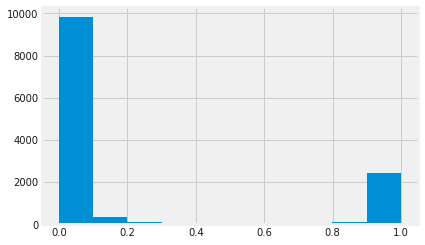

In [182]:
plt.hist(predictions)
plt.show()

In [184]:
pd.crosstab(index=real_test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
satisfaction_level,,
0.09,0,152
0.10,0,281
0.11,0,263
0.12,21,6
0.13,46,3
0.14,62,3
0.15,70,0
0.16,62,0
0.17,62,1
